In [1]:
#!pip install -U transformers datasets

In [2]:
## Importation des librairies
# Manipulation des données
import pandas as pd
import numpy as np
import re

# Deep Learning
import torch

# HuggingFace Transformers
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

# HuggingFace Datasets
from datasets import Dataset

# Métriques
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# gestion des warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning),
warnings.filterwarnings("ignore", category=SyntaxWarning)



In [3]:
# Utilisation du GPU pour rapidite d'entrainement
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [4]:
# Chargement du dataset SMS Spam depuis un S3 publique.
url = "https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep%20Learning/project/spam.csv"
df = pd.read_csv(url, encoding="latin-1")

In [5]:
df.shape

(5572, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
# Nettoyage des colonnes inutiles et renommage pour plus de clarté.
df = df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
df.columns = ["label", "text"]
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## PREPROCESSING

In [8]:
# Preprocessing minimal, BERT étant déjà pré-entraîné sur du texte brut,
# --> Retrait des majuscules, caractères spéciaux, normalisation des espaces

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text_clean"] = df["text"].apply(clean_text)


In [9]:
df["label"] = df["label"].map({"ham": 0, "spam": 1})
df.head()


,label,text,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...


## Creation du dataset Hugging Face

In [10]:
dataset = Dataset.from_pandas(df[["text_clean", "label"]])
dataset

Dataset({
    features: ['text_clean', 'label'],
    num_rows: 5572
})

In [11]:
# Tokenization:
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [12]:
# Fonction de tokenisation avec padding et truncation
def tokenize(batch):
    return tokenizer(
        batch["text_clean"],
        padding="max_length",
        truncation=True,
        max_length=64
    )

In [13]:
# Application de la fonction:
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.remove_columns(["text_clean"])
dataset.set_format("torch")

Map:   0%|          | 0/5572 [00:00<?, ? examples/s]

In [14]:
# separation train et test
split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split["train"]
test_dataset = split["test"]


In [15]:
# Utilisation du Transfer Learning - distilbert
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

model.to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [16]:
# Parametres d'entrainement:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    save_strategy="no"
)

## Metriques

In [17]:
# Definition des metriques pour classification binaire SPAM/NON SPAM
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [18]:
# Initialisation de l'entrainement:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


In [19]:
# Entrainement local, pas d'enregistrement (ex Weights & Biases)
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.050700,0.030742,0.992825,0.985816,0.958621,0.972028
2,0.019600,0.038444,0.991928,0.978873,0.958621,0.968641
3,0.002000,0.039788,0.991928,0.978873,0.958621,0.968641


TrainOutput(global_step=837, training_loss=0.04454487003163483, metrics={'train_runtime': 162.4832, 'train_samples_per_second': 82.292, 'train_steps_per_second': 5.151, 'total_flos': 221402698428672.0, 'train_loss': 0.04454487003163483, 'epoch': 3.0})

### Commentaire des resultats:
Une loss ≈ 0.04 est très faible

Le modèle a bien convergé

3 epochs ont suffi (le transfer learning a bien aide a l'apprentissage)

In [21]:
# Evaluation sur le test set
results = trainer.evaluate()
results

{'eval_loss': 0.03978801891207695,
 'eval_accuracy': 0.9919282511210762,
 'eval_precision': 0.9788732394366197,
 'eval_recall': 0.9586206896551724,
 'eval_f1': 0.9686411149825784,
 'eval_runtime': 2.2223,
 'eval_samples_per_second': 501.736,
 'eval_steps_per_second': 31.499,
 'epoch': 3.0}

Accuracy — 99.19 %

Le modèle classe correctement presque tous les SMS, mais il faut s'assurer que le modele predit bien les actuels SPAM (vrais positifs) a l'aide d'autres metriques.

## Matrice de confusion

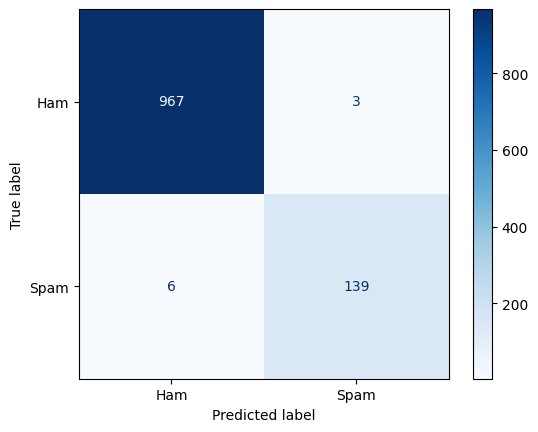

In [22]:
# Visualisation:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Ham", "Spam"])
disp.plot(cmap="Blues")
plt.show()


Le modele trouve 3 resultats classe Spam par erreur, soit une precision de 97.
3 sur un total de 142 spam trouves.

Le modele n'a pas reussi a detecter 6 spam, classé Ham sur un total de 145 spam reels. Soit un recall de 95.86%

Le f1-score, qui presente l'equilibre entre ces 2 metriques est de 96,9% ce qui est satisfaisant.

## Amelioration des performances

Je decide de dopper mon modele grace a un apprentissage plus long de 5 epocs. J'ajoute egalement un seuil de prediction defini pour tenter d'ameliorer ma prediction.

In [24]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # évaluation à la fin de chaque epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # ← on passe de 3 à 5 epochs
    weight_decay=0.01,
    logging_steps=50,
    save_strategy="no"
)


In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.011500,0.054433,0.992825,0.985816,0.958621,0.972028
2,0.000600,0.071177,0.989238,0.946309,0.972414,0.959184
3,0.000100,0.066893,0.992825,0.979021,0.965517,0.972222
4,0.008300,0.071863,0.991031,0.965517,0.965517,0.965517
5,0.000100,0.071379,0.992825,0.979021,0.965517,0.972222


TrainOutput(global_step=1395, training_loss=0.0052116530750440865, metrics={'train_runtime': 138.2356, 'train_samples_per_second': 161.21, 'train_steps_per_second': 10.091, 'total_flos': 369004497381120.0, 'train_loss': 0.0052116530750440865, 'epoch': 5.0})

In [29]:
import numpy as np

# prédictions sur le test set
preds = trainer.predict(test_dataset)
y_probs = np.argmax(preds.predictions, axis=1)  # valeurs 0 ou 1 par défaut

# exemple pour un threshold différent (ici 0.4 pour spam)
# Cela va augmenter le recall, donc détecter plus de spams.
y_pred_threshold = (preds.predictions[:,1] > 0.4).astype(int)

In [30]:
# Evaluation sur le test set
results = trainer.evaluate()
results

{'eval_loss': 0.0713794082403183,
 'eval_accuracy': 0.9928251121076234,
 'eval_precision': 0.9790209790209791,
 'eval_recall': 0.9655172413793104,
 'eval_f1': 0.9722222222222222,
 'eval_runtime': 2.0432,
 'eval_samples_per_second': 545.701,
 'eval_steps_per_second': 34.259,
 'epoch': 5.0}

Recall ~96.55 % vs 95,86% → détecte encore mieux les spams, léger gain par rapport à 3 epochs.
Cela n'a pas ete au detriment de la performance generale du modele avec une accuracy de 99.3 %et F1-score ameliore 97.22%.

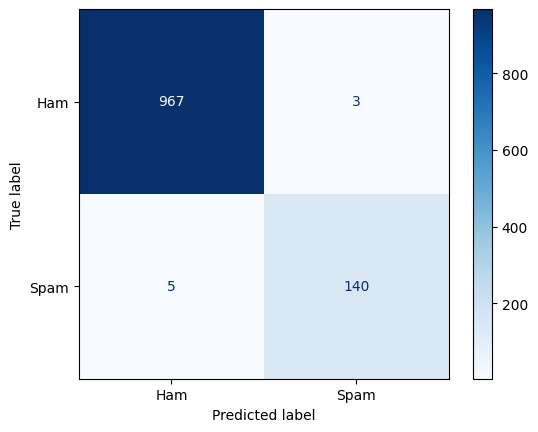

In [31]:
# Visualisation:
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Ham", "Spam"])
disp.plot(cmap="Blues")
plt.show()


Grace a ce model ameliore, seulement 3 predictions SPAM s'avere fausses. Ce qui peut etre satisfaisant mais a la fois un probleme utilisateurs si ces 3 messages sont importants.

Toutefois, l'utilisateur sera satisfait d'avoir 97% des spams filtres.

L'idée serait de diminuer ce nombre de 3 en ajustant légèrement le seuil de classification ou en combinant le modèle avec des règles simples de filtrage, afin d’attraper ces spams restants sans trop augmenter le nombre de messages légitimes bloqués.

Un travail appprofondie, necessiterait d'analyser les spams non detectes et de creer certaines regles supplementaires basees sur des donnees de sens ou de forme. Par exemple, la presence de '!' que nous avons volontairement retirés.

Une autre perspective pourrait etre d'utiliser un autre modele pour comparer rapidement avec BERT-base, ALBERT.

## Conclusion
Dans ce projet, nous avons prétraité et nettoyé un dataset de SMS, puis entraîné un modèle de classification basé sur DistilBERT pour détecter les spams.

Grâce au fine-tuning sur 5 epochs, le modèle atteint une accuracy de 99,3 %, avec une précision de 97,9 %, un rappel de 96,6 % et un F1-score de 97,2 %, ce qui démontre une excellente capacité à identifier les messages indésirables tout en limitant les faux positifs.

Ces performances permettent de mettre en place un filtre SMS fiable éliminant la grande majorité des spams tout en préservant les messages légitimes.